In [1]:
#import the libraries

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Add, ReLU, Dense
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

In [2]:
#Conv-BatchNorm-ReLU block

def conv_batchnorm_relu(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    return x

In [3]:
#Identity block

def identity_block(tensor, filters):
    
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=1)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
    x = BatchNormalization()(x)
    
    x = Add()([tensor,x])    #skip connection
    x = ReLU()(x)
    
    return x

In [4]:
#Projection block

def projection_block(tensor, filters, strides):
    
    #left stream
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=strides)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
    x = BatchNormalization()(x)
    
    #right stream
    shortcut = Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut,x])    #skip connection
    x = ReLU()(x)
    
    return x

In [5]:
#Resnet block

def resnet_block(x, filters, reps, strides):
    
    x = projection_block(x, filters, strides)
    for _ in range(reps-1):
        x = identity_block(x,filters)
        
    return x

In [6]:
#Model

input = Input(shape=(224,224,3))

x = conv_batchnorm_relu(input, filters=64, kernel_size=7, strides=2)
x = MaxPool2D(pool_size = 3, strides =2)(x)
x = resnet_block(x, filters=64, reps =3, strides=1)
x = resnet_block(x, filters=128, reps =4, strides=2)
x = resnet_block(x, filters=256, reps =6, strides=2)
x = resnet_block(x, filters=512, reps =3, strides=2)
x = GlobalAvgPool2D()(x)

output = Dense(1000, activation ='softmax')(x)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

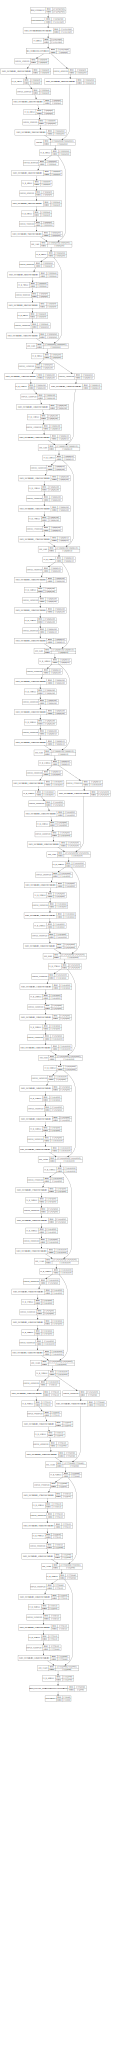

In [7]:
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=60, subgraph=False).create(prog='dot',format='svg'))